In [1]:
%load_ext autoreload
%autoreload 2 

In [1]:
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from utils import (
    auprc,
    factor_enrichment_gsea,
    generate_k_fold,
    get_gprofiler,
    perturbation_signal_recovery,
    read_aws_csv,
    read_aws_h5ad,
    read_aws_pickle,
    retrieve_stringdb_neighbors,
    set_seed,
)

In [ ]:
# read in trained model outputs generated from ./PertSpectra_load_checkpoints/pertspectra_inhouse.ipynb
adata = read_aws_h5ad(
    "s3://pert-spectra/PertSpectra_checkpoints/pertspectra_inhouse/fold_0.h5ad"
)

# Reconstruction

## Spearman Coefficient
- Spearman correlation between predicted and observed expression of test set
- Compute correlation for the mean expression aggregated on perturbation, across all kfolds

In [8]:
n_folds = 5
model_adatas = []
for n in range(0, n_folds):
    # new adata
    adata_n = adata.copy()
    # load model from checkpoint
    s3_dir = "s3://pert-spectra/PertSpectra_checkpoints/"
    experiment_name = "pertspectra_inhouse/"
    model_name = f"fold_{n}.h5ad"
    m_adata = read_aws_h5ad(s3_dir + experiment_name + model_name)
    model_adatas.append(m_adata)

In [11]:
# iterate through all models and get the losses and correlations
# take the mean loss and correlation for the test set
from scipy.stats import spearmanr

test_corr_singles = []
test_corr_combos = []

set_seed(0)

for n in range(n_folds):
    adata_n = model_adatas[n]
    train_idx, val_idx, test_idx = generate_k_fold(
        adata_n, adata_n.X, adata_n.obs["condition"], fold_idx=n
    )
    loss_weights = np.ones(adata_n.shape[0])
    adata_test = adata_n[test_idx]

    for pert in adata_test.obs["condition"].unique():
        hold_idx = [
            i
            for i, x in enumerate(
                adata_test[adata_test.obs["Treatment"] == "TNFA+"].obs["condition"]
            )
            if x == pert
        ]
        recon = adata_test.uns["recon"]
        # correlation
        mean_reconstruction = recon.mean(axis=0)
        mean_observed = np.squeeze(
            np.array(
                adata_test[adata_test.obs["Treatment"] == "TNFA+"][hold_idx].X.mean(
                    axis=0
                )
            )
        )
        if ("+" in pert) and ("ctrl" not in pert):
            test_corr_combos.append(
                [pert, spearmanr(mean_reconstruction, mean_observed)[0], n]
            )
        else:
            test_corr_singles.append(
                [pert, spearmanr(mean_reconstruction, mean_observed)[0], n]
            )

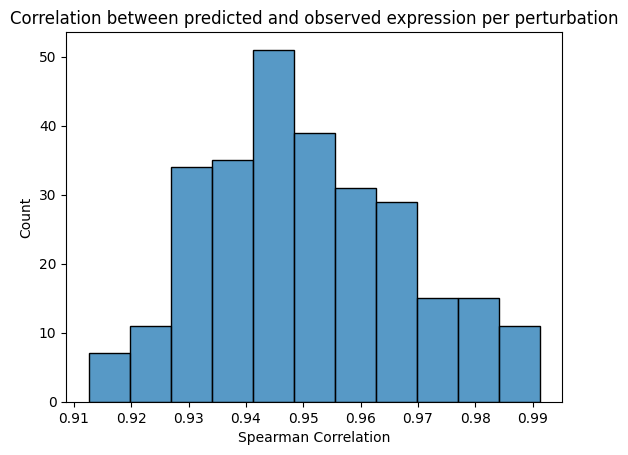

In [12]:
# plot train correlation distribution vs test correlation distribution
test_corr = np.array(test_corr_singles + test_corr_combos)[:, 1].astype(float)
sns.histplot(test_corr, label="test_corr")
plt.title("Correlation between predicted and observed expression per perturbation")
plt.xlabel("Spearman Correlation")
plt.show()

In [11]:
np.savetxt(
    "figures/reconstruction_spearmans/pertspectra_inhouse_spearman_correlations.csv",
    test_corr,
    delimiter=",",
    fmt="%.2f",
)

# Perturbation Embedding Heatmap

## Hierarchical Clustering + Enrichment
- Perform enrichment tests (gprofiler) on hierarchical clustering of perturbation embeddings

In [ ]:
from scipy.spatial.distance import pdist, squareform

# Compute the pairwise distances
tnfa_pos_pert_embeddings_df = pd.DataFrame(
    adata.uns["SPECTRA_pert_scores"], index=adata.uns["Spectra_pert_labels"]
)
df = tnfa_pos_pert_embeddings_df.drop(index=["basal", "ctrl", "intergenic"])

distance = "euclidean"
distances = pdist(df.values, metric=distance)

# Convert the distances into a square distance matrix
distance_matrix = pd.DataFrame(squareform(distances), index=df.index, columns=df.index)
clustermap = sns.clustermap(distance_matrix, cmap="viridis_r")
clustermap.fig.suptitle(f"Pairwise {distance} distance of perturbation latent vectors")
# clustermap.ax_row_dendrogram.set_visible(False)
clustermap.ax_col_dendrogram.set_visible(False)
plt.show()

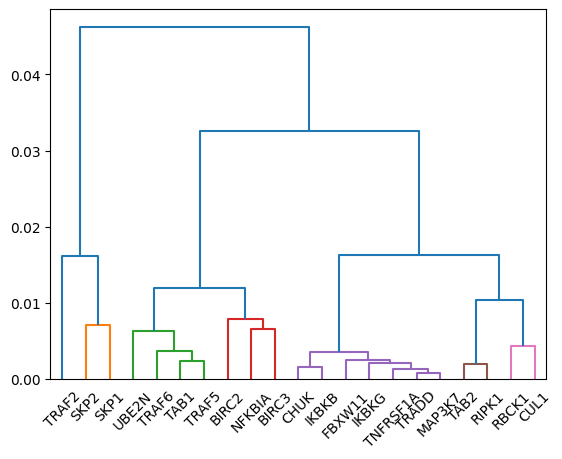

In [5]:
from scipy.cluster.hierarchy import dendrogram

den = dendrogram(
    clustermap.dendrogram_col.linkage,
    labels=distance_matrix.index,
    color_threshold=0.01,
)

In [8]:
# extract clusters and perform gprofiler
from collections import defaultdict


def get_cluster_classes(den, label="ivl"):
    cluster_idxs = defaultdict(list)
    for c, pi in zip(den["color_list"], den["icoord"]):
        for leg in pi[1:3]:
            i = (leg - 5.0) / 10.0
            if abs(i - int(i)) < 1e-5:
                cluster_idxs[c].append(int(i))
    cluster_classes = {}
    for c, l in cluster_idxs.items():  # noqa
        i_l = [den[label][i] for i in l]
        cluster_classes[c] = i_l
    return cluster_classes


clusters = get_cluster_classes(den)
# extract functions for clusters
cluster_process = {}
for c in clusters:
    cluster_df = pd.DataFrame(clusters[c], columns=["gene_symbol"])
    res = get_gprofiler(cluster_df)
    cluster_process[c] = res[res["p_value"] <= 0.05]

In [10]:
# save grpofiler results
with open(
    "figures/pert_embedding_cluster_gprofiler/pertspectra_inhouse_pert_emb_gprofiler.pickle",
    "wb",
) as handle:
    pickle.dump(cluster_process, handle, protocol=pickle.HIGHEST_PROTOCOL)

## PR Curve+AUC
- AUCPR using prior graph as binary label

In [10]:
aucpr_df, f1_df, pr_dict = auprc(distance_matrix)
print(aucpr_df)
print(f1_df)
aucpr_df.to_csv("figures/pert_embedding_recall/pertspectra_inhouse_aucpr.csv")
f1_df.to_csv("figures/pert_embedding_recall/pertspectra_inhouse_f1.csv")

               AUC
StringDB  0.675809
CORUM     0.705489
                F1  Threshold
StringDB  0.697966   0.007078
CORUM     0.639556   0.160069


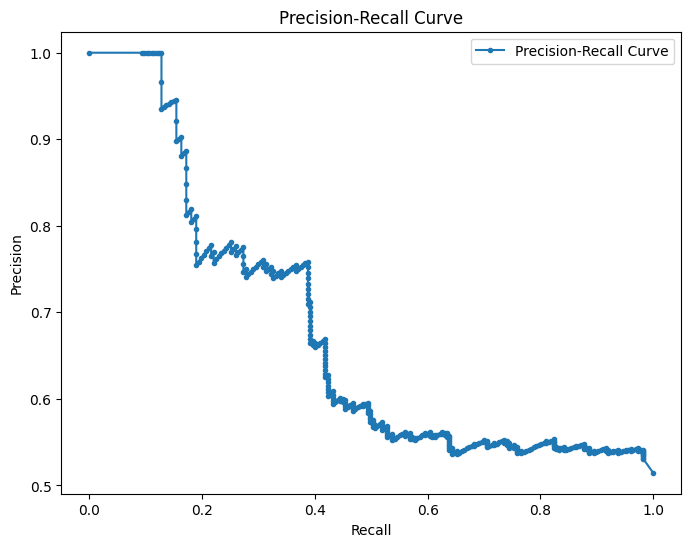

In [11]:
# Plot the precision-recall curve
prior = "StringDB"
plt.figure(figsize=(8, 6))
plt.plot(
    pr_dict[prior]["recall"],
    pr_dict[prior]["precision"],
    marker=".",
    label="Precision-Recall Curve",
)
# Adding labels and title
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
# Save the plot
plt.show()

# Interpretability of our learned latent space

## Factor Enrichment
- GSEA on log transformed latent-by-gene factors
- Then associate each perturbation to its top latent factors

In [ ]:
factor_to_go = factor_enrichment_gsea(adata, adata.uns["SPECTRA_factors"], fdr=1e-2)

In [14]:
# filter and add description to processes
go_df = read_aws_csv("s3://pert-spectra/references/GO_to_Description.txt")
go_df.set_index("Term", inplace=True)
go_dict = go_df.to_dict()["Description"]

filtered_factor_to_go = {}
for i in factor_to_go:
    proc = factor_to_go[i]
    proc["descr"] = [go_dict[x] for x in proc["GO_ID"]]
    filtered_factor_to_go[i] = proc

In [15]:
# save latent enrichment results
with open(
    "figures/factor_enrichments/pertspectra_inhouse_factor_enrichment.pickle", "wb"
) as handle:
    pickle.dump(filtered_factor_to_go, handle, protocol=pickle.HIGHEST_PROTOCOL)

## Overlap with prior knowledge/ground truth (stringdb)
- Group A: a set of GO terms associated with a perturbation (either drivers from msigdb, or from literature) and its neighbors in stringdb
- Group B: a set of GO terms from the interpretability analysis
- Hypergeometric test on the overlap of the two groups

In [16]:
# load precomputed factor_to_go dict if available
filtered_factor_to_go = read_aws_pickle(
    "s3://pert-spectra/figures/factor_enrichments/pertspectra_inhouse_factor_enrichment.pickle"
)

In [ ]:
# get neighbors for each perturbation
pert_neighbors = retrieve_stringdb_neighbors(adata.uns["Spectra_pert_labels"])

In [23]:
# construct group A - known processes for each perturbation
gene_sets = read_aws_pickle("s3://pert-spectra/references/GO_to_Gene.pickle")
# BP only go terms
go_reference = read_aws_csv("s3://pert-spectra/references/GO_terms.txt.gz", zipped=True)
go_bp = go_reference[go_reference["go_category"] == "biological_process"]
go_bp_ids = set(go_bp["go_id"].values)
filtered_go_terms = {key: gene_sets[key] for key in go_bp_ids if key in gene_sets}

# GO terms per perturbation AND its neighbors in stringdb
pert_to_go = {key: set() for key in adata.uns["Spectra_pert_labels"]}
for goterm in filtered_go_terms:
    for pert in adata.uns["Spectra_pert_labels"]:
        if pert in filtered_go_terms[goterm] and set(
            filtered_go_terms[goterm]
        ).intersection(pert_neighbors[pert]):
            pert_to_go[pert].add(goterm)

In [24]:
# construct set B - model identified processes for each perturbation
n = 2  # number of top factors to get processes from
model_pert_to_go = {}
for pert in adata.uns["Spectra_pert_labels"]:
    if pert in ["ctrl", "intergenic", "basal"]:
        continue
    # get top factors
    tnfa_pos_pert_embeddings_df = pd.DataFrame(
        adata.uns["SPECTRA_pert_scores"], index=adata.uns["Spectra_pert_labels"]
    )
    pert_loading = tnfa_pos_pert_embeddings_df.loc[pert]
    intergenic_loading = tnfa_pos_pert_embeddings_df.loc["intergenic"]
    delta_loading = np.abs(np.log(pert_loading) - np.log(intergenic_loading))
    top_n_factors = np.argpartition(np.array(delta_loading), -n)[-n:]
    # get processes
    model_processes = set()
    for f in top_n_factors:
        proc = filtered_factor_to_go[f]
        model_processes = model_processes.union(set(proc["Term"]))
    model_pert_to_go[pert] = model_processes

In [25]:
pvals = perturbation_signal_recovery(
    pert_to_go,
    model_pert_to_go,
    list(filtered_go_terms.keys()),
    list(adata.uns["Spectra_pert_labels"]),
)

Overlap for SKP2: 2 out of 6 in researchDB
P-value for SKP2: 0.005521122949289679
Overlap for NFKBIA: 4 out of 28 in researchDB
P-value for NFKBIA: 0.0018530509193777707
Overlap for TRAF2: 12 out of 29 in researchDB
P-value for TRAF2: 9.372890092145309e-14
Overlap for BIRC2: 12 out of 30 in researchDB
P-value for BIRC2: 1.5352819800190863e-13
Overlap for TAB1: 6 out of 9 in researchDB
P-value for TAB1: 9.880142853042106e-07
Overlap for UBE2N: 6 out of 16 in researchDB
P-value for UBE2N: 3.5981263241025083e-07
Overlap for CHUK: 12 out of 21 in researchDB
P-value for CHUK: 8.970401417521286e-16
Overlap for RBCK1: 8 out of 11 in researchDB
P-value for RBCK1: 4.469976857613242e-09
Overlap for IKBKB: 15 out of 24 in researchDB
P-value for IKBKB: 1.262837991043831e-14
Overlap for TNFRSF1A: 12 out of 21 in researchDB
P-value for TNFRSF1A: 3.557360199375414e-11
Overlap for TRAF6: 14 out of 46 in researchDB
P-value for TRAF6: 8.701845914835026e-14
Overlap for BIRC3: 8 out of 20 in researchDB
P-

In [26]:
# save as csv for visualization
pd.DataFrame.from_dict(data=pvals, orient="index").to_csv(
    "figures/process_recovery_hypergeo_pvals/MODEL_inhouse_hypergeo_neighbors_recovery_pvalues.csv",
    header=False,
)